In [1]:
import pandas as pd
import numpy as np
import h5py
import torch
import torch.nn as nn
import random
import sys
import os

#trying to ensure reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [2]:
# Setting path to load util functions
from pathlib import Path
parent_dir = Path.cwd().parents[1]
sys.path.append(os.path.abspath(parent_dir))

In [3]:
experiment_num = 18

In [4]:
#Loading data
with h5py.File('../../data/3d_array/mod_train_data_3d_h5.h5', 'r') as f:
    train_X = f['train_data_3d'][:]
with h5py.File('../../data/3d_array/mod_val_data_3d_h5.h5', 'r') as f:
    val_X = f['val_data_3d'][:]
with h5py.File('../../data/3d_array/mod_test_data_3d_h5.h5', 'r') as f:
    test_X = f['test_data_3d'][:]

train_y = pd.read_parquet('../../data/3d_array/train_targets.parquet')
val_y = pd.read_parquet('../../data/3d_array/val_targets.parquet')
test_y = pd.read_parquet('../../data/3d_array/test_targets.parquet')

In [5]:
train_X = np.nan_to_num(train_X, nan=0.0)
val_X = np.nan_to_num(val_X, nan=0.0)
test_X = np.nan_to_num(test_X, nan=0.0)

In [6]:
train_y['end_of_month'].value_counts()

end_of_month
2018-03-31    289115
Name: count, dtype: int64

In [7]:
train_y = train_y[train_y['end_of_month'].isin(['2018-03-31'])]
val_y = val_y[val_y['end_of_month'].isin(['2018-03-31'])]
test_y = test_y[test_y['end_of_month'].isin(['2018-03-31'])]

C:\Users\vaseekaranv\AppData\Local\Temp\ipykernel_25148\847019464.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  train_y = train_y[train_y['end_of_month'].isin(['2018-03-31'])]
C:\Users\vaseekaranv\AppData\Local\Temp\ipykernel_25148\847019464.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  val_y = val_y[val_y['end_of_month'].isin(['2018-03-31'])]
C:\Users\vaseekaranv\AppData\Local\Temp\ipykernel_25148\847019464.py:3: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be c

In [8]:
train_y.sort_values(by=['customer_ID'])

,customer_ID,end_of_month,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-31,0
1,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,2018-03-31,0
2,000084e5023181993c2e1b665ac88dbb1ce9ef621ec537...,2018-03-31,0
3,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2018-03-31,0
4,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2018-03-31,1
...,...,...,...
289110,fffe3ec7cdbc1caac845c884b389ed347bfc1da9d09731...,2018-03-31,1
289111,fffef3305f19a11fb6c15f4ebe9be1bd664540e57c0a6a...,2018-03-31,0
289112,ffff39cc22a375d07369980d02d617883dd28ad81a6aa3...,2018-03-31,0
289113,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,2018-03-31,0


In [9]:
train_X.shape, train_y.shape

((289115, 13, 86), (289115, 3))

In [10]:
val_X.shape, val_y.shape

((32124, 13, 86), (32124, 3))

In [11]:
class SmallConvLSTMModelWithLSTMSkip(nn.Module):
    def __init__(self, input_size, hidden_size, fc_size, output_size=1, conv_out_channels=32, kernel_size=3):
        super(SmallConvLSTMModelWithLSTMSkip, self).__init__()

        # Conv1D layer (no skip connection here now)
        self.conv1d = nn.Conv1d(in_channels=input_size,
                                out_channels=conv_out_channels,
                                kernel_size=kernel_size,
                                padding=kernel_size//2) # 'same' padding
        self.conv_relu = nn.ReLU() # Activation for Conv output

        # LSTM layer
        self.lstm = nn.LSTM(conv_out_channels, hidden_size, batch_first=True)

        # Projection layer for the LSTM skip connection
        # This projects the LSTM input features (conv_out_channels) from the last time step
        # to match the LSTM hidden state dimension (hidden_size) for addition.
        self.lstm_skip_projection = nn.Linear(conv_out_channels, hidden_size)

        # Fully connected layers
        self.fc = nn.Linear(hidden_size, fc_size) # Takes combined LSTM output (still hidden_size)
        self.fc_relu = nn.ReLU() # Added ReLU activation for the FC layer
        self.output = nn.Linear(fc_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Input shape: batch_size x time_steps x features (input_size)

        # --- Conv Block (Sequential - no skip) ---
        # Conv1D expects: batch_size x features(channels) x time_steps
        x_permuted = x.permute(0, 2, 1)
        # x_permuted shape: batch_size x input_size x time_steps

        # Apply Conv1D and then ReLU
        conv_out = self.conv1d(x_permuted)
        activated_conv_out = self.conv_relu(conv_out)
        # activated_conv_out shape: batch_size x conv_out_channels x time_steps
        # --- End Conv Block ---

        # Rearrange for LSTM: batch_size x time_steps x features (now conv_out_channels)
        lstm_input = activated_conv_out.permute(0, 2, 1)
        # lstm_input shape: batch_size x time_steps x conv_out_channels

        # --- LSTM Block with Skip Connection ---
        # Pass through LSTM layer
        lstm_out, _ = self.lstm(lstm_input)
        # lstm_out shape: batch_size x time_steps x hidden_size

        # Get the output of the last time step from LSTM
        lstm_last_out = lstm_out[:, -1, :]
        # lstm_last_out shape: batch_size x hidden_size

        # Skip Connection: Get the input to the LSTM corresponding to the last time step
        lstm_input_last = lstm_input[:, -1, :]
        # lstm_input_last shape: batch_size x conv_out_channels

        # Project the last input step to match the hidden size dimension
        projected_skip = self.lstm_skip_projection(lstm_input_last)
        # projected_skip shape: batch_size x hidden_size

        # Add the LSTM output (last step) and the projected input (last step)
        combined_lstm_out = lstm_last_out + projected_skip
        # combined_lstm_out shape: batch_size x hidden_size
        # --- End LSTM Block ---

        # Fully connected layers
        fc_out = self.fc(combined_lstm_out)
        fc_out = self.fc_relu(fc_out) # Apply ReLU activation after FC layer
        # fc_out shape: batch_size x fc_size

        # Final output layer
        output = self.output(fc_out)
        # output shape: batch_size x output_size

        # Apply sigmoid for binary classification
        return self.sigmoid(output)

In [12]:
# Example usage
input_size = train_X.shape[2]  # Number of features
hidden_size = 64  # Hidden state size for LSTM
fc_size = 32  # Size of the fully connected layer
conv_out_channels = 32  # Number of output channels for Conv1D
kernel_size = 3  # Kernel size for Conv1D

model = SmallConvLSTMModelWithLSTMSkip(
    input_size=input_size, 
    hidden_size=hidden_size, 
    fc_size=fc_size,
    conv_out_channels=conv_out_channels,
    kernel_size=kernel_size
)

In [13]:
batch_size = 10000
from torchinfo import summary
summary(model, input_size=(batch_size, train_X.shape[1], train_X.shape[2]), device='cpu',
        col_names=["input_size", "kernel_size","output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Kernel Shape              Output Shape              Param #
SmallConvLSTMModelWithLSTMSkip           [10000, 13, 86]           --                        [10000, 1]                --
├─Conv1d: 1-1                            [10000, 86, 13]           [3]                       [10000, 32, 13]           8,288
├─ReLU: 1-2                              [10000, 32, 13]           --                        [10000, 32, 13]           --
├─LSTM: 1-3                              [10000, 13, 32]           --                        [10000, 13, 64]           25,088
├─Linear: 1-4                            [10000, 32]               --                        [10000, 64]               2,112
├─Linear: 1-5                            [10000, 64]               --                        [10000, 32]               2,080
├─ReLU: 1-6                              [10000, 32]               --                        [10000, 32]               --
├─Line


(process:26816): Pango-WARNING **: 10:51:40.842: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


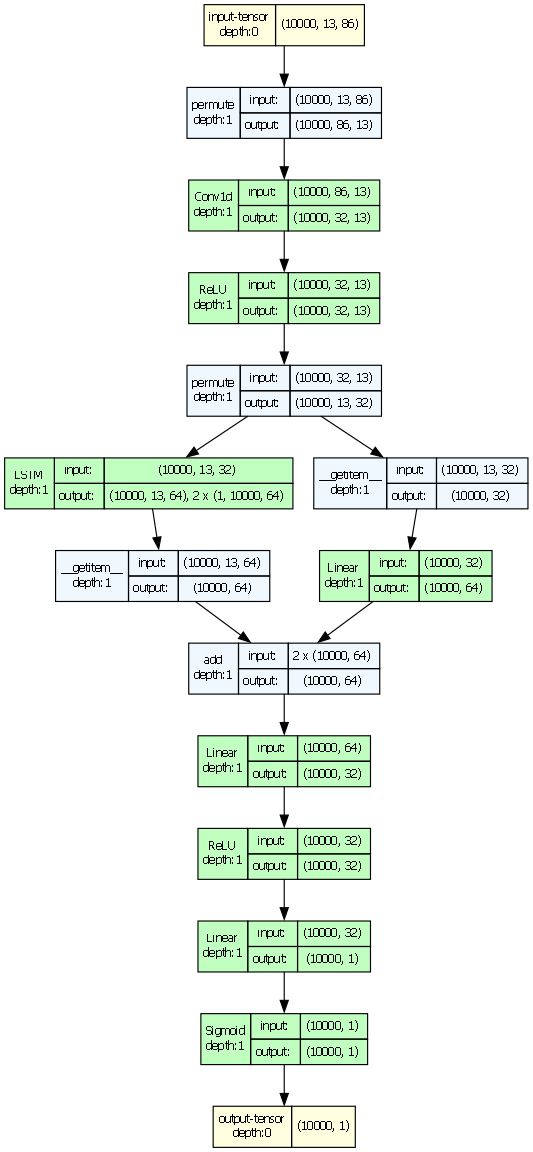

In [14]:
import graphviz
graphviz.set_jupyter_format('png')
from torchview import draw_graph

model_graph = draw_graph(model, input_size=(batch_size, train_X.shape[1], train_X.shape[2]), device='meta', depth = 3)
model_graph.visual_graph

In [14]:
from torch.utils.data import Dataset, DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets):
        """
        Args:
            data: numpy array of shape (num_ids, time_steps, features)
            targets: numpy array of shape (num_ids,)
        """
        self.data = torch.FloatTensor(data)
        self.targets = torch.FloatTensor(targets).unsqueeze(1)  # Add dimension for output
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [15]:
train_dataset = TimeSeriesDataset(train_X, train_y['target'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [16]:
val_dataset = TimeSeriesDataset(val_X, val_y['target'].values)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [17]:
test_dataset = TimeSeriesDataset(test_X, test_y['target'].values)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
train_dataset.__getitem__(0)[0].shape, train_dataset.__getitem__(0)[1]

(torch.Size([13, 86]), tensor([0.]))

In [19]:
val_dataset.__getitem__(0)[0].shape, val_dataset.__getitem__(0)[1]

(torch.Size([13, 86]), tensor([1.]))

In [20]:
from sklearn.metrics import roc_auc_score
import time
import copy
from tqdm.auto import tqdm

import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 20
patience = 3  # Number of epochs to wait for improvement before early stopping

# Initialize variables for early stopping
best_val_loss = float('inf')
best_val_auc = 0.0
best_model_wts = copy.deepcopy(model.parameters)
no_improve_epochs = 0

# For tracking metrics
train_losses = []
val_losses = []
val_aucs = []

# Move model to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Training on {device}")
start_time = time.time()

# Training loop

# Modify the training loop to include progress bars
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    
    # Add tqdm progress bar for training loop
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
        # Update progress bar with current loss
        train_pbar.set_postfix({'loss': loss.item()})
    
    epoch_train_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    # Add tqdm progress bar for validation loop
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]", leave=False)
    with torch.no_grad():
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            
            # Collect predictions and labels for AUC calculation
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Update progress bar with current loss
            val_pbar.set_postfix({'loss': loss.item()})
    
    # Calculate metrics
    epoch_val_loss = running_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)
    
    all_preds = [p[0] for p in all_preds]  # Flatten predictions
    all_labels = [l[0] for l in all_labels]  # Flatten labels
    epoch_val_auc = roc_auc_score(all_labels, all_preds)
    val_aucs.append(epoch_val_auc)
    
    # Print epoch statistics
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, "
          f"Val AUC: {epoch_val_auc:.4f}")
    
    # Check if this is the best model
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_val_auc = epoch_val_auc
        best_model_wts = copy.deepcopy(model.state_dict())
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
    
    # Early stopping
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break


# Training complete
time_elapsed = time.time() - start_time
print(f"Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
print(f"Best val loss: {best_val_loss:.4f}, Best val AUC: {best_val_auc:.4f}")

# Load best model weights
model.load_state_dict(best_model_wts)

Training on cuda:0


Epoch 1/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 1/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/20 - Train Loss: 0.5903, Val Loss: 0.3617, Val AUC: 0.9213


Epoch 2/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 2/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/20 - Train Loss: 0.3045, Val Loss: 0.2764, Val AUC: 0.9381


Epoch 3/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 3/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/20 - Train Loss: 0.2689, Val Loss: 0.2600, Val AUC: 0.9446


Epoch 4/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 4/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/20 - Train Loss: 0.2593, Val Loss: 0.2544, Val AUC: 0.9472


Epoch 5/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 5/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/20 - Train Loss: 0.2548, Val Loss: 0.2511, Val AUC: 0.9483


Epoch 6/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 6/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/20 - Train Loss: 0.2523, Val Loss: 0.2498, Val AUC: 0.9489


Epoch 7/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 7/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/20 - Train Loss: 0.2509, Val Loss: 0.2512, Val AUC: 0.9493


Epoch 8/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 8/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/20 - Train Loss: 0.2504, Val Loss: 0.2483, Val AUC: 0.9495


Epoch 9/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 9/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/20 - Train Loss: 0.2488, Val Loss: 0.2476, Val AUC: 0.9499


Epoch 10/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 10/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/20 - Train Loss: 0.2482, Val Loss: 0.2472, Val AUC: 0.9501


Epoch 11/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 11/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/20 - Train Loss: 0.2472, Val Loss: 0.2463, Val AUC: 0.9503


Epoch 12/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 12/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/20 - Train Loss: 0.2468, Val Loss: 0.2460, Val AUC: 0.9504


Epoch 13/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 13/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/20 - Train Loss: 0.2462, Val Loss: 0.2457, Val AUC: 0.9505


Epoch 14/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 14/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/20 - Train Loss: 0.2456, Val Loss: 0.2453, Val AUC: 0.9507


Epoch 15/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 15/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/20 - Train Loss: 0.2451, Val Loss: 0.2441, Val AUC: 0.9510


Epoch 16/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 16/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/20 - Train Loss: 0.2445, Val Loss: 0.2440, Val AUC: 0.9512


Epoch 17/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 17/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/20 - Train Loss: 0.2442, Val Loss: 0.2438, Val AUC: 0.9513


Epoch 18/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 18/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/20 - Train Loss: 0.2435, Val Loss: 0.2438, Val AUC: 0.9513


Epoch 19/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 19/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/20 - Train Loss: 0.2430, Val Loss: 0.2428, Val AUC: 0.9516


Epoch 20/20 [Train]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 20/20 [Valid]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/20 - Train Loss: 0.2425, Val Loss: 0.2424, Val AUC: 0.9517
Training completed in 1m 21s
Best val loss: 0.2424, Best val AUC: 0.9517


<All keys matched successfully>

In [21]:
import os

# Save the model weights

# Create directory if it doesn't exist
save_dir = '../../models/deep_learning'
os.makedirs(save_dir, exist_ok=True)

# Save model state dictionary
model_path = os.path.join(save_dir, f'experiment_{experiment_num}.pth')
torch.save(model.state_dict(), model_path)

# Save additional information for later reference
checkpoint_path = os.path.join(save_dir, f'experiment_{experiment_num}.pth')
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_loss': best_val_loss,
    'val_auc': best_val_auc,
    'input_size': input_size,
    'hidden_size': hidden_size,
    'fc_size': fc_size,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_aucs': val_aucs
}
torch.save(checkpoint, checkpoint_path)

print(f"Model saved to {model_path}")
print(f"Checkpoint saved to {checkpoint_path}")

Model saved to ../../models/deep_learning\experiment_18.pth
Checkpoint saved to ../../models/deep_learning\experiment_18.pth


In [22]:
# Ensure the model is in evaluation mode
model.eval()

# Initialize a list to store predictions
val_predictions = []

# Disable gradient computation for inference
with torch.no_grad():
    for inputs, _ in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        val_predictions.extend(outputs.cpu().numpy())

# Flatten the predictions
val_predictions = [p[0] for p in val_predictions]
print("Validation predictions obtained.")

Validation predictions obtained.


Target Recall: >= 0.9800 for Class 0
Threshold found by Binary Search: 0.7714648
Achieved Recall at Threshold: 0.9800
Classification Report:
              precision    recall  f1-score   support

     Class 0     0.8568    0.9800    0.9143     23806
     Class 1     0.9028    0.5313    0.6689      8318

    accuracy                         0.8638     32124
   macro avg     0.8798    0.7556    0.7916     32124
weighted avg     0.8687    0.8638    0.8507     32124



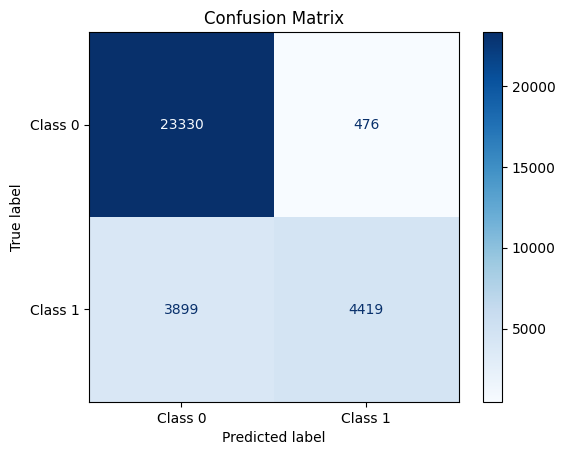

0.7714647650718689

In [23]:
from utils.eval_helpers import evaluate_model_for_recall
evaluate_model_for_recall(target_class=0, desired_recall=0.98, y_true=np.array(all_labels).astype('int'), y_pred_proba=np.array(val_predictions))

In [24]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

# Set model to evaluation mode
model.eval()

# Check if CUDA is available and move model to the appropriate device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Lists to store predictions and true values
all_preds = []
all_labels = []

# Perform inference without gradient calculation
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the appropriate device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Store predictions and labels
        all_preds.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all batches
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Convert predictions to binary (0 or 1) using threshold of 0.5
pred_classes = (all_preds > 0.5).astype(int)
true_classes = all_labels.astype(int)

# Generate classification report

# Print classification report
print("Classification Report:")
print(classification_report(true_classes, pred_classes, digits = 4))

# Calculate and print accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f"Accuracy: {accuracy:.4f}")

# Calculate and print ROC-AUC score
auc = roc_auc_score(true_classes, all_preds)
print(f"ROC-AUC Score: {auc:.4f}")

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(true_classes, pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0     0.9220    0.9288    0.9254    102026
           1     0.7918    0.7751    0.7834     35648

    accuracy                         0.8890    137674
   macro avg     0.8569    0.8519    0.8544    137674
weighted avg     0.8883    0.8890    0.8886    137674

Accuracy: 0.8890
ROC-AUC Score: 0.9505

Confusion Matrix:
[[94760  7266]
 [ 8017 27631]]


Target Recall: >= 0.9800 for Class 0
Threshold found by Binary Search: 0.7642898
Achieved Recall at Threshold: 0.9800
Classification Report:
              precision    recall  f1-score   support

     Class 0     0.8569    0.9800    0.9143    102026
     Class 1     0.9028    0.5316    0.6692     35648

    accuracy                         0.8639    137674
   macro avg     0.8799    0.7558    0.7918    137674
weighted avg     0.8688    0.8639    0.8509    137674



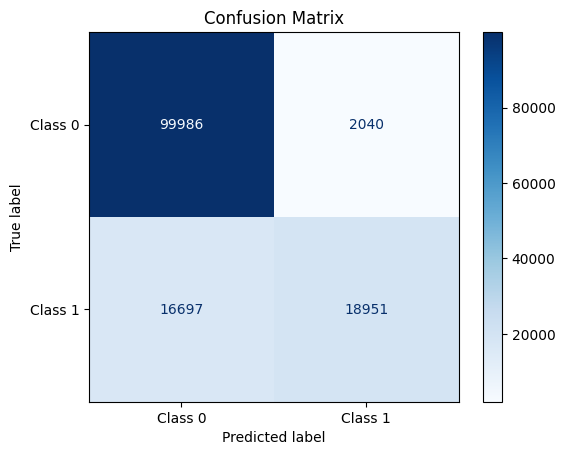

0.7642897963523865

In [25]:
evaluate_model_for_recall(target_class=0, desired_recall=0.98, y_true=true_classes, y_pred_proba=all_preds)